In [108]:
# Set retina display
%config InlineBackend.figure_format = 'retina'

Generation of synthetic data

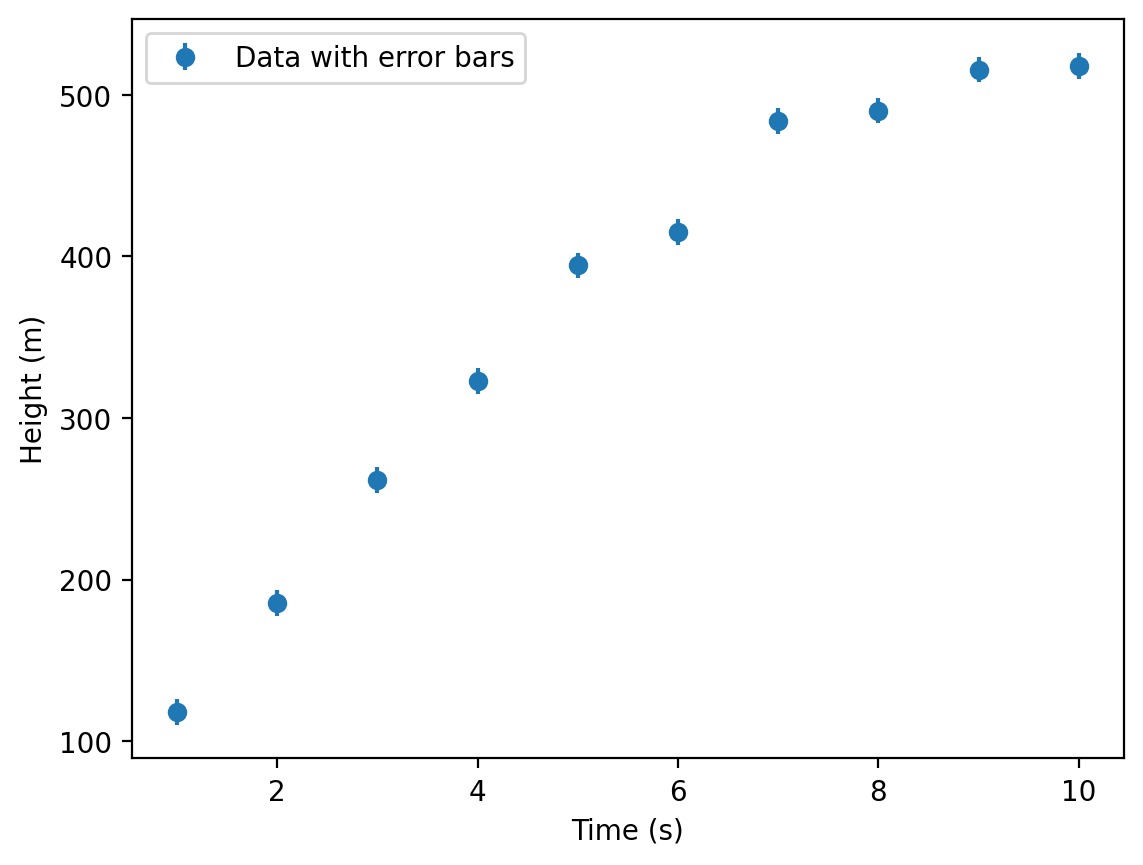

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(1)

sigma = 8
m_true = np.array([10, 100, 9.8])

## Independent, i.e. time, variable
t = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
## Design matrix
G = np.vstack((np.ones(t.shape), t, -0.5 * t**2)).T
## Synthetic data with random noise
y = m_true[0] + m_true[1] * t - 0.5 * m_true[2] * t**2 + np.random.normal(0, sigma, size=t.shape)

## Plotting function
def plot_data(t, y, sigma):
    fig, ax = plt.subplots()
    ax.errorbar(t, y, sigma, fmt='o', label='Data with error bars')
    ax.set(xlabel='Time (s)', ylabel='Height (m)')
    return ax

ax = plot_data(t, y, sigma)
ax.legend()
plt.show()

---
## $L2$ regression

In [110]:
def LS(y, G, Cd=None):
    """
    Least squares (LS) solution for linear regression.
    Params:
        y: The target vector.
        G: The design matrix.
        Cd: The data covariance matrix.
    """
    if Cd is None:
        m = np.linalg.inv(G.T @ G) @ G.T @ y
    else:
        m = np.linalg.inv(G.T @ Cd @ G) @ (G.T @ Cd @ y)
    return m

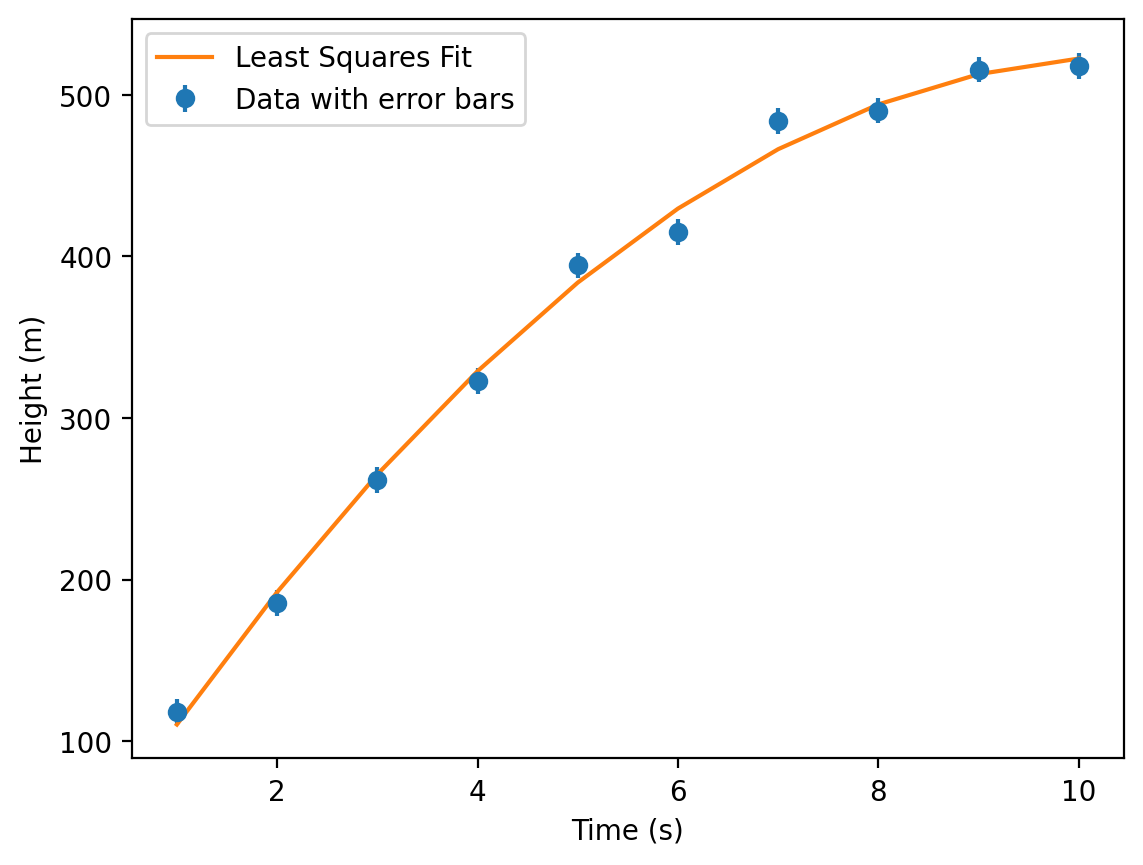

In [111]:
# Least squares model solution
m_L2 = LS(y, G)
# Computed Model covariance
m_L2_cov = np.linalg.inv(G.T @ G) * sigma**2

ax = plot_data(t, y, sigma)
ax.plot(t, G @ m_L2, label='Least Squares Fit')
ax.legend()
plt.show()

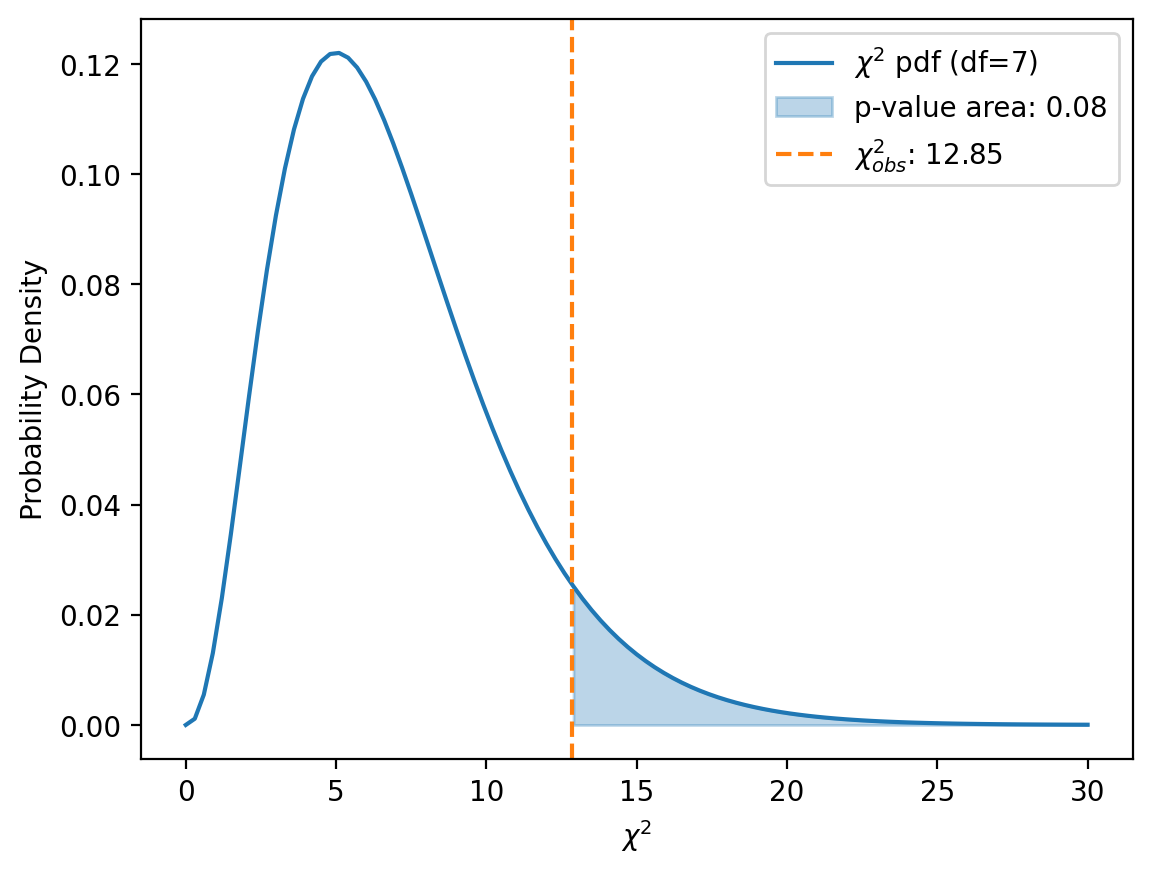

In [112]:
from scipy.stats import chi2

# Compute chi-squared statistic using known sigma
chi2_obs = np.sum((G @ m_L2 - y)**2) / sigma**2
# Degrees of freedom
degrees_of_freedom = len(y) - len(m_L2)
# P-value test
p_value = 1 - chi2.cdf(chi2_obs, df=degrees_of_freedom)


fig, ax = plt.subplots()
x = np.linspace(0, 30, 101)
chi2_pdf = chi2.pdf(x, df=degrees_of_freedom)
ax.plot(x, chi2_pdf, label=f'$\\chi^2$ pdf (df={degrees_of_freedom})')
ax.fill_between(x, 0, chi2_pdf, where=(x > chi2_obs), color='C0', alpha=0.3, label=f'p-value area: {p_value:.2f}')
ax.axvline(chi2_obs, color='C1', linestyle='--', label=f'$\\chi^2_{{obs}}$: {chi2_obs:.2f}')
ax.set(xlabel='$\\chi^2$', ylabel='Probability Density')

ax.legend()
plt.show()

In [113]:
sigma_est = np.linalg.norm(G @ m_L2 - y) / np.sqrt(degrees_of_freedom)
print (sigma_est)

10.837530868193848


---
## $L1$ regression

In [114]:
def IRLS(y, G, epsilon=1e-6, tau=1e-2, max_iter=100):
    """
    Iteratively reweighted least squares (IRLS) for robust L1-regression.
    Params:
        y: The target vector.
        G: The design matrix.
        epsilon: A small value to avoid division by zero.
        tau: Convergence threshold.
        max_iter: Maximum number of iterations.
    """
    # Start with L2 solution as an initial guess
    m = np.linalg.inv(G.T @ G) @ G.T @ y
    for _ in range(max_iter):
        # Data residuals
        r = y - G @ m
        # Water mask tiny residuals to avoid zero division
        r[np.abs(r) < epsilon] = epsilon
        
        R = np.diag(1 / np.abs(r))
        # Update model
        # m_new = np.linalg.inv(G.T @ R @ G) @ G.T @ R @ y
        m_new = LS(y, G, Cd=R)
        if np.linalg.norm(m_new - m) / (1 + np.linalg.norm(m_new)) < tau: break
        m = m_new
    return m

Challenge: compute p(1)_value using 2.95 to 2.100 in Aster et al. (2013).

In [115]:
# from scipy.stats import norm
# def p1_value(mu_obs, degrees_of_freedom):
#     sigma1 = np.sqrt((1 - 2/np.pi) * degrees_of_freedom)
#     gamma = 


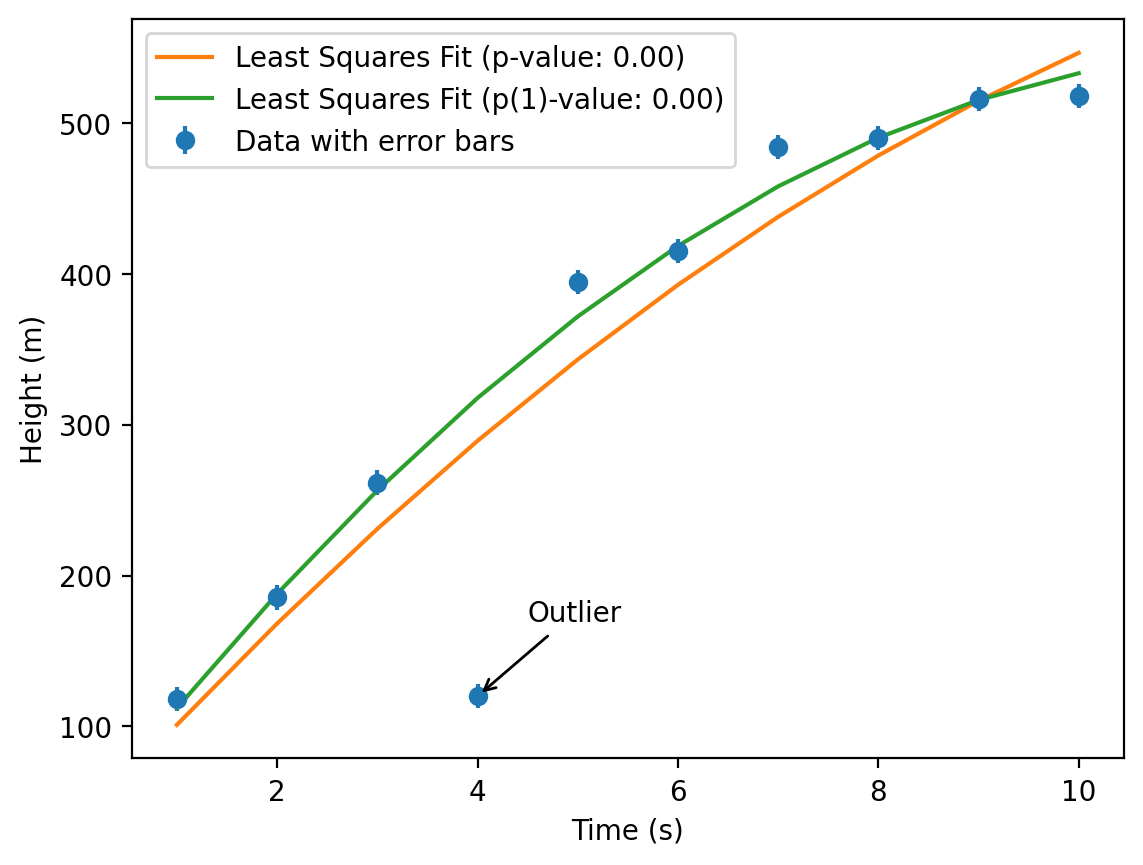

In [116]:
y[3] = 120

ax = plot_data(t, y, sigma)

m_L2 = np.linalg.inv(G.T @ G) @ G.T @ y
chi2_obs = np.sum((G @ m_L2 - y)**2) / sigma**2
p_value = 1 - chi2.cdf(chi2_obs, df=degrees_of_freedom)
ax.plot(t, G @ m_L2, label=f'Least Squares Fit (p-value: {p_value:.2f})')
ax.annotate(xy=(t[3], y[3]), xytext=(t[3]+0.5, y[3]+50), text='Outlier', arrowprops=dict(arrowstyle='->'))

m_L1 = IRLS(y, G)
ax.plot(t, G @ m_L1, label=f'Least Squares Fit (p(1)-value: {p_value:.2f})')

ax.legend()
plt.show()

Monte-Carlo error propagation

In [117]:
m_L1_array = []
for _ in range(10000):
    # _y = m_true[0] + m_true[1] * t - 0.5 * m_true[2] * t**2 + np.random.normal(0, sigma, size=t.shape)
    _y = m_L1[0] + m_L1[1] * t - 0.5 * m_L1[2] * t**2 + np.random.normal(0, sigma, size=t.shape)
    m_L1_array.append(IRLS(_y, G))

m_L1_cov = np.cov(m_L1_array, rowvar=False)